# Beyond text -  Machine reading over multi-modal scientific documents


## Motivation and goals

In previous notebooks of the **[tutorial](http://hybridnlp.expertsystemlab.com/tutorial)** we illustrated the benefits of combining neural representations and structured knowledge in natural language processing. **In this notebook we take a step further and show how to address multi-modality** in domains where not only text but also images are relevant sources of information for the task at hand. 

More specifically, **we focus on the analysis of scientific bibliography**, where text is usually supplemented with figure, charts and diagrams. This notebook provides a deep dive on the methods originally presented in the paper: **[Look, Read and Enrich - Learning from Scientific Figures and their Captions](https://arxiv.org/abs/1909.09070)**. 

As illustrated in the paper, **dealing with scientific figures is significantly harder than natural images. However, there is a valuable source of supervision in scientific documents that until now remained untapped: the correspondence between a figure and its caption**.

Here, we teach how to leverage such observation through a **Figure-Caption Correspondence (FCC) task that learns text and visual features that can be used in different transfer learning scenarios.** In this notebook we apply the FCC features to solve text and figure classification and multi-modal machine comprehension for question answering.

As demonstrated in the paper, **the use of pre-trained semantic embeddings extracted from a knowledge graph using [Vecsigrafo ](http://www.semantic-web-journal.net/content/vecsigrafo-corpus-based-word-concept-embeddings-bridging-statistic-symbolic-1) further enriches the FCC features**. Over the notebook we focus on this type of transfer learning.





##Overview of the notebook

The remainder of the notebook is structured around the following experiments:

1.   **Training and evaluation of the FCC task**, used to jointly learn text and visual features from scientific bibliography. **This includes the use of pre-trained embeddings from a knowledge graph learnt through the Vecsigrafo approach**.
2.   **A qualitative anaysis of the resulting features** so that you can see by yourself the information captured by them.
3.   **A comparison between state of the art algorithms used in image-sentence matching and the FCC task**. This will allow you to better understand the limitations of applying state of the art image-sentence matching techniques to the scientific domain. 
4.  **Textual and visual classification over the SciGraph taxonomy** using figures and their captions as input.
5.  **Multi-modal question answering** involving text but also diagrams over the TQA dataset.

In addition to this notebook, all the related code and data used for the experimentation in the paper can be found in [GitHub](https://github.com/hybridNLP/look_read_and_enrich).

## Preliminary steps

First, we import the Python libraries necessary to run our experiments.

In [0]:
!pip install scipy==1.1.0

In [0]:
import json
import cv2
from pandas import DataFrame
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Embedding, Concatenate, Conv1D, MaxPooling1D, Multiply, Dense
from keras.optimizers import Adam
from keras.utils import plot_model
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from collections import Counter
from vis.visualization import visualize_cam

The datasets we use for training and evaluation are the following:
*   [**The Semantic Scholar Corpus**](https://www.aclweb.org/anthology/N18-3011/), with 39M articles. From them, we download those which are available and accessible (3,3M PDFs) and extracted over 12M figures and captions. From them, we select a random sample of 500K to train FCC plus another 500K to train Vecsigrafo.
*   [**Springer Nature's SciGraph** ](https://www.springernature.com/gp/researchers/scigrap), with 7M scientific publications organized in 22 scientific fields or categories. Since SciGraph does not include the PDFs, we select the intersection with Semantic Scholar, which resulted in 80K papers and 82K figures and captions.
*   [**The Textbook Question Answering corpus**](http://vuchallenge.org/tqa.html), which includes 1,076 lessons and 26,260 multi-modal test questions from middle school science curricula.

**For the purpose of the tutorial (and its time constraints), we limit the size of the dataset to only 400 figures and captions to train the FCC task**. As you imagine, this falls way too short to train a performant model. So, whenever necessary we will use the weights resulting from training over the whole corpus. If you wish to give them a go, the datasets we used in the paper are available [in our GitHub repository](https://github.com/hybridNLP/look_read_and_enrich).

Next, we clone the repository with the datasets and other materials.

In [0]:
!git clone https://github.com/hybridnlp/tutorial.git

Cloning into 'tutorial'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 478 (delta 6), reused 2 (delta 0), pack-reused 462
Receiving objects: 100% (478/478), 452.74 MiB | 13.24 MiB/s, done.
Resolving deltas: 100% (250/250), done.
Checking out files: 100% (100/100), done.


We uncompress the zip files:

In [0]:
!unzip -q tutorial/datasamples/scigraph.zip
!unzip -q tutorial/datasamples/tqa.zip

The figures and captions are structured as json files. Let us take a look at them. You can change the index variable to retrieve different samples as you like.

FIGURE PATH: ./scigraph/1752-1947-8-200-Figure2-1.png
CAPTION: Abdominal X-ray revealing several air-fluid levels of the small bowel and a large air-fluid level of the sigmoid colon.


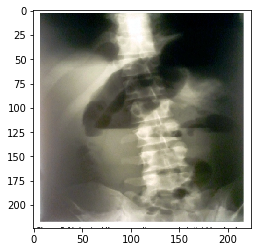

In [0]:
index = 0 #first figure and caption

with open("./tutorial/datasamples/scigraph_wordnet.json", "r", encoding="utf-8", errors="surrogatepass") as file:
  dataset = json.load(file)

print("FIGURE PATH: ./scigraph/" + dataset[index]["img_file"])
print("CAPTION: " + dataset[index]["captions"][0])

im = cv2.imread("./scigraph/"+dataset[index]["img_file"])
plt.imshow(im)
plt.show()



  

## 1. FIGURE-CAPTION CORRESPONDENCE

In essence, FCC is a binary classification task that receives a figure and a caption and determines whether they correspond or not. For training, the positive pairs are actual figures and their captions from a collection of scientific publications. Negative pairs are extracted from combinations of figures and any other randomly selected captions. The network is then made to learn text and visual features from scratch, without additional labelled data.

### 1.1. Loading the dataset

To illustrate the training of the FCC task, we focus on the SciGraph corpus. First, we save in a list all the figures and their captions. For the text part, we keep not only the tokens, but also their associated WordNet synsets resulting from word-sense disambiguation. This is a necessary step to enrich the text features with the semantic (lemma and synset) embeddings of each token.

As in previous notebooks, we use Cogito to tokenize the text and WordNet as the knowledge graph used for word-sense disambiguation. In the paper we use Sensigrafo, which is Expert System's proprietary knowledge graph.

In [0]:
list_figures_paths = []
list_captions_tokens = []
list_captions_synsets = []


with open("./tutorial/datasamples/scigraph_wordnet.json", "r", encoding="utf-8", errors="surrogatepass") as file:
  dataset = json.load(file)

for doc in dataset:
  list_figures_paths.append("./scigraph/" + doc["img_file"])
  list_captions_tokens.append(doc["captions_tokens"][0])
  list_captions_synsets.append(doc["captions_synsets"][0])
  
print("Number of figures = " + str(len(list_figures_paths)))
print("Number of captions (tokens) = " + str(len(list_figures_paths)))
print("Number of captions (synsets) = " + str(len(list_figures_paths)))

Number of figures = 400
Number of captions (tokens) = 400
Number of captions (synsets) = 400


Once we have our three lists with figure paths, caption tokens and caption synsets, we transform them into tensors. 

First, we create numpy arrays from the figures using the PIL library:

In [0]:
figures = []
for figure_path in tqdm(list_figures_paths,total=len(list_figures_paths)):
  f_img = open(figure_path, 'rb')
  im = Image.open(f_img)
  arr = np.array(im.convert(mode='RGB'))
  im.close()
  f_img.close()
  figures.append(arr)
figures = np.array(figures)
print("SHAPE OF FIGURES TENSOR: " + str(np.shape(figures)))

100%|██████████| 400/400 [00:00<00:00, 1012.63it/s]


SHAPE OF FIGURES TENSOR: (400, 224, 224, 3)


Then, we:

1.   create two Keras tokenizers, one for caption tokens and another for their synsets, 
2.   create word indexes for both modalities, and 
3.   transform the captions in sequence arrays with a length of 1,000 tokens each.


In [0]:
MAX_SEQ_LEN = 1000

In [0]:
caption_types = [list_captions_tokens, list_captions_synsets]
tokenizers = []
captions = []

for lst_cpt in caption_types:
  tokenizer = Tokenizer(filters='')
  tokenizer.fit_on_texts(lst_cpt)
  tokenizers.append(tokenizer)
  sequences = tokenizer.texts_to_sequences(lst_cpt)
  data_text = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")
  captions.append(data_text)
tokenizer_tokens, tokenizer_synsets = tokenizers
captions_tokens, captions_synsets = captions

print("SIZE OF TOKENS VOCABULARY: " + str(len(tokenizer_tokens.word_index)))
print("SIZE OF SYNSETS VOCABULARY: " + str(len(tokenizer_synsets.word_index)))
print("SHAPE OF TOKENS SEQUENCES: " + str(np.shape(captions_tokens)))
print("SHAPE OF SYNSETS SEQUENCES: " + str(np.shape(captions_synsets)))

SIZE OF TOKENS VOCABULARY: 2934
SIZE OF SYNSETS VOCABULARY: 1559
SHAPE OF TOKENS SEQUENCES: (400, 1000)
SHAPE OF SYNSETS SEQUENCES: (400, 1000)


### 1.2. Semantic embeddings

For each word $w_k$ in the vocabulary, the FCC network learns an embedding $\vec{w}_k$ that can be combined with pre-trained word $\vec{w'}_k$, lemma $\vec{l}_k$ and concept $\vec{c}_k$ embeddings to produce a single vector $\vec{t}_k$. If no pre-trained knowledge is transferred from an external source, then $\vec{t}_k=\vec{w}_k$. 

The equation below shows the different combinations of learnt and pre-trained embeddings we consider:

$$ \vec{t}_k =
\begin{cases}
    \vec{w}_k & \quad (a) \\
    [\vec{w}_k; \vec{w'}_k] & \quad (b)\\
    [\vec{w}_k; \vec{l}_k; \vec{c}_k] & \quad (c)\\
\end{cases} $$

To clarify:

<ol type="a">
  <li>corresponds to word embeddings learnt by the network upon training over the corpus only.</li>
  <li>concatenates learnt and pre-trained word embeddings.</li>
  <li>concatenates learnt word embeddings and pre-trained semantic (lemma and concept) embeddings.</li>
</ol>

In [0]:
index = 0  #first figure

caption_token = dataset[index]["captions_tokens"][0]
caption_synset = dataset[index]["captions_synsets"][0]

tabl = [list(i) for i in zip(*[caption_token.split(" "), caption_synset.split(" ")])]

DataFrame(tabl,columns=["tokens","synsets"])

,tokens,synsets
0,abdominal,wn31_abdominal.a.01
1,x-ray,wn31_x-ray.v.01
2,revealing,wn31_bring+out.v.01
3,several,wn31_respective.a.01
4,air,wn31_air+out.v.01
5,-,None
6,fluid,wn31_fluent.a.01
7,levels,wn31_level.n.05
8,of,None
9,the,None


For conciseness, here we focus on configuration $(c)$, where word, lemma and concept embeddings are concatenated in a 300 dimension vector (100 dimensions for words, lemmas and embeddings each). All the .tsv files of the embeddings are also available in GitHub.

In [0]:
EMB_FILE = "./tutorial/datasamples/scigraph_wordnet.tsv"
DIM = 100

First we extract the embeddings from the .tsv and put them in two dictionaries (embeddings_index_tokens and embeddings_index_synsets):

In [0]:
file = open(EMB_FILE, "r", encoding="utf-8", errors="surrogatepass")
embeddings_index_tokens = {}
embeddings_index_synsets = {}

for line in file:
  values = line.split()
  comp_len = len(values)-DIM
  word = "+".join(values[0:comp_len])
  if (line.startswith("wn31")):
    vector = np.asarray(values[comp_len:], dtype='float32')
    embeddings_index_synsets[word] = vector
  else:
    if (line.startswith("grammar#")):
      continue
    else:
      vector = np.asarray(values[comp_len:], dtype='float32')
      embeddings_index_tokens[word] = vector
file.close()

embedding_indexes = [embeddings_index_tokens, embeddings_index_synsets]

print("NUMBER OF TOKENS IN THE EMBEDDINGS: " + str(len(embeddings_index_tokens)))
print("NUMBER OF SYNSETS IN THE EMBEDDINGS: " + str(len(embeddings_index_synsets)))

NUMBER OF TOKENS IN THE EMBEDDINGS: 19438
NUMBER OF SYNSETS IN THE EMBEDDINGS: 9232


Now we take every word and its disambiguated synset and fetch their pre-trained embeddings from the dictionaries to build the embeddings matrices for the model. In case of OOV words we use an array of zeros for that token during the training of the FCC task.

In [0]:
embedding_matrices = []
for tok_i in range(len(tokenizers)):
  embedding_matrix = np.zeros((len(tokenizers[tok_i].word_index) + 1, DIM))
  for word, i in tokenizers[tok_i].word_index.items():
    embedding_vector = embedding_indexes[tok_i].get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
  embedding_matrices.append(embedding_matrix)
embedding_matrix_tokens, embedding_matrix_synsets = embedding_matrices

print("SHAPE OF TOKENS MATRIX: " + str(np.shape(embedding_matrix_tokens)))
print("SHAPE OF SYNSETS MATRIX: " + str(np.shape(embedding_matrix_synsets)))

SHAPE OF TOKENS MATRIX: (2935, 100)
SHAPE OF SYNSETS MATRIX: (1560, 100)


### 1.3. FCC network architecture

We use a 2-branch neural architecture with three main parts: the vision and language subnetworks, respectively extracting visual and text features, and a fusion subnetwork to evaluate figure-caption correspondence. 

The **vision subnetwork** follows a VGG-style design, with 3x3 convolutional filters, 2x2 max-pooling layers with stride 2 and no padding. 

In [0]:
modelFigures = Sequential()
modelFigures.add(InputLayer(input_shape=(224,224,3)))
modelFigures.add(Conv2D(64, (3,3), padding = "same", activation="relu"))
modelFigures.add(BatchNormalization())
modelFigures.add(Conv2D(64, (3,3), padding = "same", activation="relu"))
modelFigures.add(BatchNormalization())
modelFigures.add(MaxPooling2D(2))
modelFigures.add(Conv2D(128, (3,3), padding = "same", activation="relu"))
modelFigures.add(BatchNormalization())
modelFigures.add(Conv2D(128, (3,3), padding = "same", activation="relu"))
modelFigures.add(BatchNormalization())
modelFigures.add(MaxPooling2D(2))
modelFigures.add(Conv2D(256, (3,3), padding = "same", activation="relu"))
modelFigures.add(BatchNormalization())
modelFigures.add(Conv2D(256, (3,3), padding = "same", activation="relu"))
modelFigures.add(BatchNormalization())
modelFigures.add(MaxPooling2D(2))
modelFigures.add(Conv2D(512, (3,3), padding = "same", activation="relu"))
modelFigures.add(BatchNormalization())
modelFigures.add(Conv2D(512, (3,3), padding = "same", activation="relu")) 
modelFigures.add(BatchNormalization())
modelFigures.add(MaxPooling2D((28,28),2))
modelFigures.add(Flatten())

print(modelFigures.summary())













Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 1

The **language subnetwork** has 3 convolutional blocks, each with 512 filters and a 5-element window size with ReLU activation and a input sequence length of 1,000 tokens.

In [0]:
modelCaptionsScratch = Sequential()
modelCaptionsScratch.add(Embedding(len(tokenizer_tokens.word_index)+1, DIM, embeddings_initializer="uniform", input_length=MAX_SEQ_LEN, trainable=True))
modelCaptionsVecsiTokens = Sequential()
modelCaptionsVecsiTokens.add(Embedding(len(tokenizer_tokens.word_index) + 1, DIM, weights = [embedding_matrix_tokens], input_length = MAX_SEQ_LEN, trainable = False))
modelCaptionsVecsiSynsets = Sequential()
modelCaptionsVecsiSynsets.add(Embedding(len(tokenizer_synsets.word_index) + 1, DIM, weights = [embedding_matrix_synsets], input_length = MAX_SEQ_LEN, trainable = False))
modelMergeEmbeddings = Concatenate()([modelCaptionsScratch.output,modelCaptionsVecsiTokens.output,modelCaptionsVecsiSynsets.output])
modelMergeEmbeddings = Conv1D(512, 5, activation="relu")(modelMergeEmbeddings)
modelMergeEmbeddings = MaxPooling1D(5)(modelMergeEmbeddings)
modelMergeEmbeddings = Conv1D(512, 5, activation="relu")(modelMergeEmbeddings)
modelMergeEmbeddings = MaxPooling1D(5)(modelMergeEmbeddings)
modelMergeEmbeddings = Conv1D(512, 5, activation="relu")(modelMergeEmbeddings)
modelMergeEmbeddings = MaxPooling1D(35)(modelMergeEmbeddings)
modelMergeEmbeddings = Flatten()(modelMergeEmbeddings)
modelCaptions = Model([modelCaptionsScratch.input,modelCaptionsVecsiTokens.input,modelCaptionsVecsiSynsets.input], modelMergeEmbeddings)

print(modelCaptions.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_2_input (InputLayer)  (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_3_input (InputLayer)  (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    293500      embedding_1_input[0][0]          
____________________________________________________________________________________________

The **fusion subnetwork** calculates the element-wise product of the 512-D visual and text feature vectors produced by last blocks of each subnetwork into a single vector $r$ to produce a 2-way classification output (correspond or not). The probability of each choice is the softmax of $r$, i.e. $\hat{y} = softmax(r) \in \mathbb{R}^{2}$. 

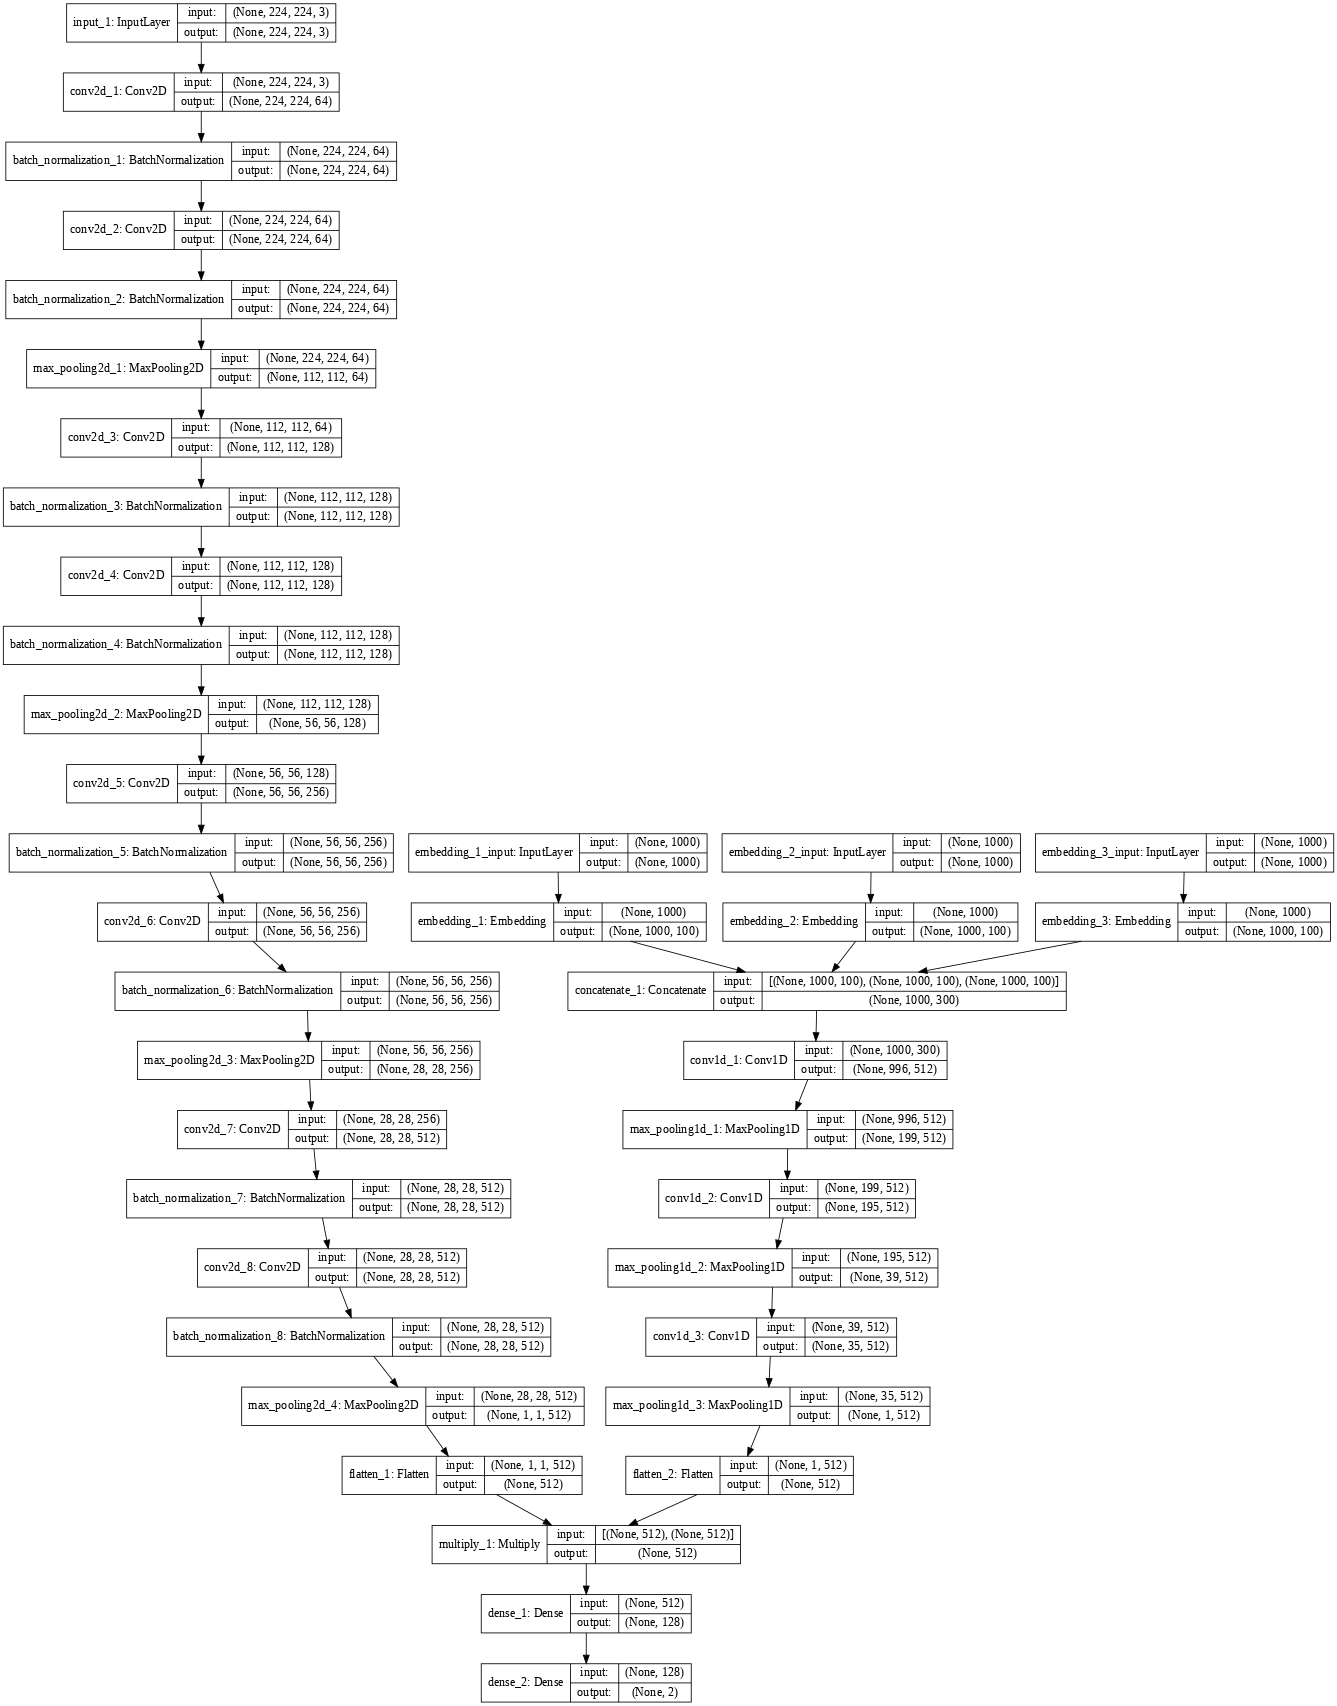

In [0]:
adam = Adam(lr=1e-4,decay=1e-5)

mergedOut = Multiply()([modelCaptions.output,modelFigures.output])  
mergedOut = Dense(128, activation='relu')(mergedOut)
mergedOut = Dense(2, activation='softmax')(mergedOut)
model = Model([modelCaptionsScratch.input,modelCaptionsVecsiTokens.input,modelCaptionsVecsiSynsets.input, modelFigures.input], mergedOut)

model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["categorical_accuracy"])

plot_model(model, show_shapes=True, to_file='model.png', dpi=60)

### 1.4. Quantitative analysis

We evaluate our method in the task it was trained to solve: determining whether a figure and a caption correspond. Next, we define some hyperparameters:

In [0]:
EPOCHS = 4
BATCH_SIZE = 16

The next generator introduces 32 inputs for every batch, balanced in terms of positive and negative cases within the batches:
*   16 positive cases with a figure and its correct caption.
*   16 negative cases with a randomly selected caption for the same figure. 

For each word in the caption, three text sub-vectors are considered: token, lemma and synset.

In [0]:
def generator(indexes):
  while True:
    np.random.shuffle(indexes)
    for i in range(0, len(indexes), BATCH_SIZE):
      batch_indexes = indexes[i:i+BATCH_SIZE]
      batch_indexes.sort()

      bx,by = get_batches(batch_indexes)

      yield (bx, by)

def get_batches(batch_indexes):
  tuples_to_shuffle = []
  for batch_ind in batch_indexes:
    tuple1 = []
    tuple1.append(captions_tokens[batch_ind])
    tuple1.append(captions_tokens[batch_ind])
    tuple1.append(captions_synsets[batch_ind])
    tuple1.append(figures[batch_ind])
    tuple1.append(np.array([0,1]))
    tuples_to_shuffle.append(tuple1)
    rand_ind = random.choice([x for x in range(len(captions_tokens)) if x != batch_ind])
    tuple2 = []
    tuple2.append(captions_tokens[rand_ind])
    tuple2.append(captions_tokens[rand_ind])
    tuple2.append(captions_synsets[rand_ind])
    tuple2.append(figures[batch_ind])
    tuple2.append(np.array([1,0]))
    tuples_to_shuffle.append(tuple2)
    random.shuffle(tuples_to_shuffle)
  bx0 = []
  bx1 = []
  bx2 = []
  bx3 = []
  y = []
  for tup in tuples_to_shuffle:
    bx0.append(tup[0])
    bx1.append(tup[1])
    bx2.append(tup[2])
    bx3.append(tup[3])
    y.append(tup[4])

  return [np.array(bx0),np.array(bx1),np.array(bx2),np.array(bx3)], np.array(y)

Before we train the model, we randomly select the train and test indexes. We choose a 90% train size and a 10% test size of the whole dataset.

In [0]:
train, test = train_test_split(range(len(captions_tokens)), test_size=0.1)

Finally, we train the FCC model. With the corpus an hyperparameters proposed in the notebook, training should take around **2 minutes**. Given the very small subset of data we have selected as input, the results will very likely be rather far from those reported in paper.

In [0]:
model.fit_generator(generator(train), epochs=EPOCHS, validation_data=generator(test), steps_per_epoch=len(train)//BATCH_SIZE, validation_steps=len(test)//BATCH_SIZE)
modelFigures.save_weights("modelFigures_weights.h5")
modelCaptions.save_weights("modelCaptions_weights.h5")
model.save_weights("model_weights.h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/4
22/22 [==============================] - 34s 2s/step - loss: 0.7331 - categorical_accuracy: 0.4503 - val_loss: 0.7290 - val_categorical_accuracy: 0.4688
Epoch 2/4
22/22 [==============================] - 26s 1s/step - loss: 0.7004 - categorical_accuracy: 0.5043 - val_loss: 0.7353 - val_categorical_accuracy: 0.3125
Epoch 3/4
22/22 [==============================] - 22s 980ms/step - loss: 0.6935 - categorical_accuracy: 0.5130 - val_loss: 0.7296 - val_categorical_accuracy: 0.3958
Epoch 4/4
22/22 [==============================] - 22s 987ms/step - loss: 0.6854 - categorical_accuracy: 0.5456 - val_loss: 0.7243 - val_categorical_accuracy: 0.3750


Due to limited size of the training set used in this notebook, the results (around 50% accuracy) are merely testimonial. The table below shows the performance we achieved in the [Look, Read and Enrich paper](https://arxiv.org/abs/1909.09070):

<img src='https://github.com/hybridnlp/tutorial/blob/master/images/Table5.png?raw=true' width=55%>

**IMPORTANT DISCLAIMER!!**

Once you have trained the FCC task, you will have three files with the resulting text and visual features, along with the weights of the model. Such features can be used for the transfer learning tasks proposed in the notebook. 

However, since their performance is very limited by the small amount of data used here, their actual use in transfer learning tasks is very limited. To overcome this, **in the remainder of the notebook we use FCC features that were previously learnt from a larger SciGraph selection (82K figures and captions)**. 

You are invited to experiment with different alternatives and check the results.

In [0]:
from tutorial.scripts import lre_aux

!tar -zxvf tutorial/datasamples/model_weights.tar.gz

captions_tokens, captions_synsets = lre_aux.get_captions(list_captions_tokens, list_captions_synsets)
model = lre_aux.get_model()[2]

model_weights_BIG.h5


### 1.5. Qualitative analysis
Now, we inspect the features learnt by the FCC task to gain a deeper understanding of the syntactic and semantic patterns captured for figure and caption representation. 

**Vision features**

The analysis was carried out on an unconstrained variety of charts, diagrams and natural images from SciGraph, without filtering by figure type or scientific field. To obtain a representative sample of what the FCC network learns, we focus on the 512-D vector resulting from the last convolutional block before the fusion subnetwork.

In [0]:
modelF = lre_aux.get_figure_vis_model()

Let us pick the feature with the most significant activation over the whole dataset and select the figure that activate them most and show its heatmap. We prioritize such features with a higher maximum activation against the average activation:

In [0]:
feat_n = 4
img_n = 4

With the next code we can generate the heatmap

feat204-top1.png: 
simulation of an influenza outbreak using data from table 1 with n = 10 and n = 1000 . lines correspond to a numerical solution of the pairwise model ( 5 ) ( k = 1 solid line , k = 3 dashed line , k = 5 dotted+line ) , whilst symbols represent the average of 250 serious outbreaks ( k = 1 filled circles , k = 3 triangles , k = 5 squares ) . a homogeneous network. b erdo_s-rényi random graph




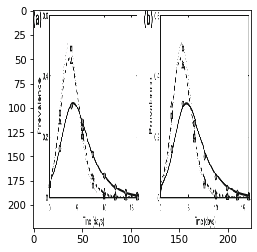

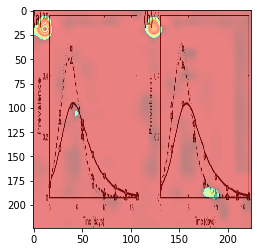

feat204-top2.png: 
a this patient developed subluxation and " head at+risk " signs , during a 6 month period of observation . note the break in shenton 's line , medial clear space widening , and lateral uncovering of the femoral head . evolving acetabular dysplasia is also evident. b an arthrogram in 25 of abduction demonstrates good containment , but unacceptable elevation of the greater+trochanter . furthermore , intertrochanteric osteotomy would shorten the limb and sacrifice abduction accordingly. c in+lieu+of an osteotomy . for containment , we chose to perform open adductor tenotomies , including the iliiopsoas , tethered the greater+trochanter , and placed him in a petrie cast for 4 weeks. d by age 9 , note the divergence of the screws , indicating differential medial growth by holding the greater+trochanter in+abeyance . he had full abductor strength and restoration of shenton 's line . the plate was removed. e presumably as a result of strong abductors , the acetabular dyspla

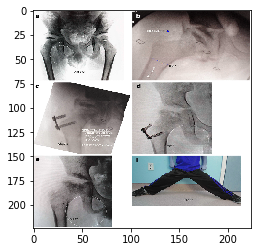

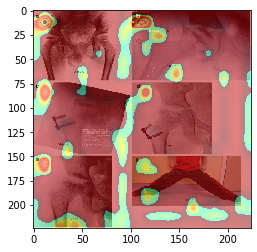

feat204-top3.png: 
prognostic value of soluble urokinase - type plasminogen activator receptor ( supar ) . box plot of ( a ) duration of mechanical ventilation and ( b ) length of stay in the icu of burn - injury patients with inhalation trauma . boxes represent the interquartile+ranges . n , number of patients per group . kaplan-meier curves showing the rate of freedom from ( c ) mechanical ventilation and ( d ) icu stay in burn - injury patients with systemic supar < 9.5 ng / ml and > 9.5 ng / ml . p values are given+in each panel .




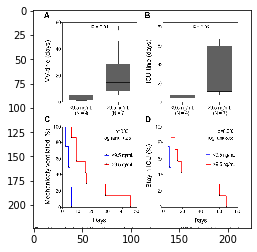

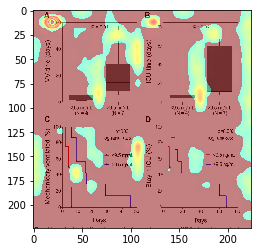

feat204-top4.png: 
cross - correlations in the gaussian variables lead to correlations of coincident level crossings. a spike correlations can arise from common input in a neuronal network. b we consider coincident level+crossings arising from two gaussian processes that share a common latent source . whenever the voltage crosses a threshold _ from below a spike is emitted . spikes are indicated by vertical solid lines . the vertical dotted+lines indicate the width of a time bin t used to compute spike counts u vi [ 0 , t ] ( _ ) , i = 1,2




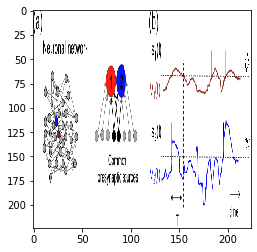

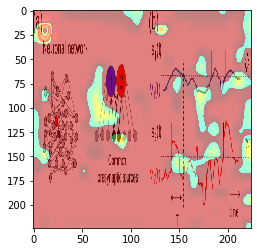

feat351-top1.png: 
simulation of an influenza outbreak using data from table 1 with n = 10 and n = 1000 . lines correspond to a numerical solution of the pairwise model ( 5 ) ( k = 1 solid line , k = 3 dashed line , k = 5 dotted+line ) , whilst symbols represent the average of 250 serious outbreaks ( k = 1 filled circles , k = 3 triangles , k = 5 squares ) . a homogeneous network. b erdo_s-rényi random graph




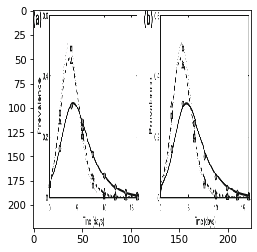

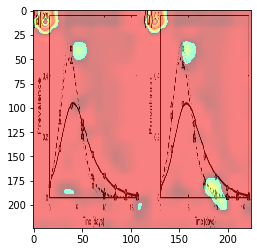

feat351-top2.png: 
cross - correlations in the gaussian variables lead to correlations of coincident level crossings. a spike correlations can arise from common input in a neuronal network. b we consider coincident level+crossings arising from two gaussian processes that share a common latent source . whenever the voltage crosses a threshold _ from below a spike is emitted . spikes are indicated by vertical solid lines . the vertical dotted+lines indicate the width of a time bin t used to compute spike counts u vi [ 0 , t ] ( _ ) , i = 1,2




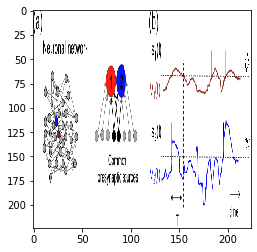

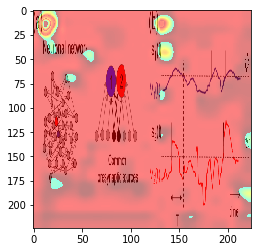

feat351-top3.png: 
a optical micrograph of a calcite grain containing crossing twins ( crossed polarizers ) . b a typical laue diffraction+pattern showing strong diffraction peaks from host domain ( some marked with squares ) and relatively weak diffraction peaks from twin domain ( some marked with circles ) . orientation maps showing the angles between sample x-axis and crystal c-axis of c the host domain and d the twin domains 1 , 2 , and 3 as indicated by the labeled arrows




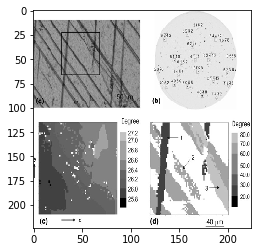

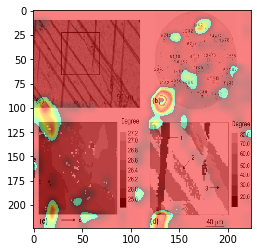

feat351-top4.png: 
simulation of a sars outbreak using data from table 1 with n = 10 and n = 1000 . lines correspond to a numerical solution of the pairwise model ( 5 ) ( k = 1 solid line , k = 3 dashed line ) , whilst symbols represent the average of 250 serious outbreaks ( k = 1 filled circles , k = 3 triangles ) . a homogeneous network. b erdo_s-rényi random graph




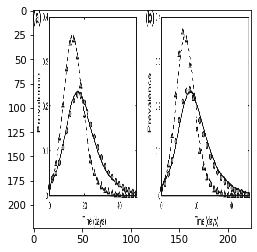

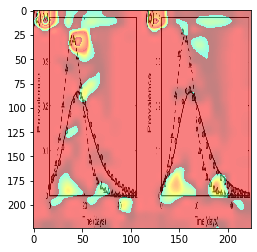

feat62-top1.png: 
simulation of an influenza outbreak using data from table 1 with n = 10 and n = 1000 . lines correspond to a numerical solution of the pairwise model ( 5 ) ( k = 1 solid line , k = 3 dashed line , k = 5 dotted+line ) , whilst symbols represent the average of 250 serious outbreaks ( k = 1 filled circles , k = 3 triangles , k = 5 squares ) . a homogeneous network. b erdo_s-rényi random graph




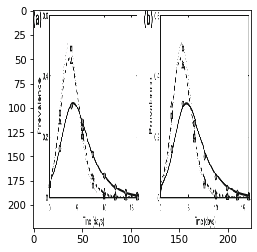

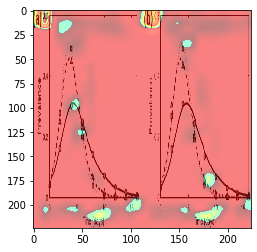

feat62-top2.png: 
cross - correlations in the gaussian variables lead to correlations of coincident level crossings. a spike correlations can arise from common input in a neuronal network. b we consider coincident level+crossings arising from two gaussian processes that share a common latent source . whenever the voltage crosses a threshold _ from below a spike is emitted . spikes are indicated by vertical solid lines . the vertical dotted+lines indicate the width of a time bin t used to compute spike counts u vi [ 0 , t ] ( _ ) , i = 1,2




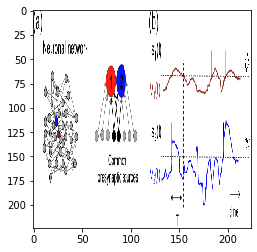

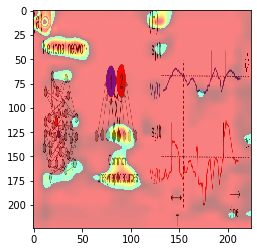

feat62-top3.png: 
prognostic value of soluble urokinase - type plasminogen activator receptor ( supar ) . box plot of ( a ) duration of mechanical ventilation and ( b ) length of stay in the icu of burn - injury patients with inhalation trauma . boxes represent the interquartile+ranges . n , number of patients per group . kaplan-meier curves showing the rate of freedom from ( c ) mechanical ventilation and ( d ) icu stay in burn - injury patients with systemic supar < 9.5 ng / ml and > 9.5 ng / ml . p values are given+in each panel .




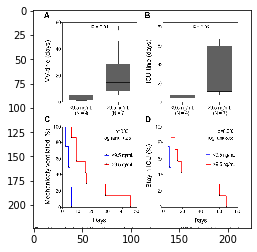

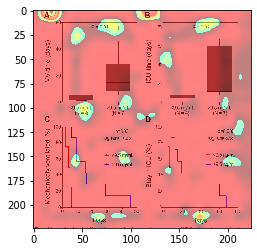

feat62-top4.png: 
figure 1




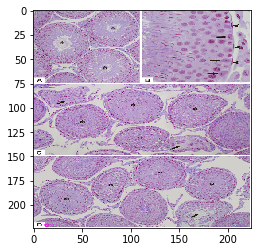

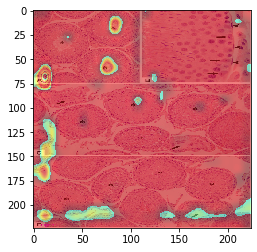

feat228-top1.png: 
simulation of an influenza outbreak using data from table 1 with n = 10 and n = 1000 . lines correspond to a numerical solution of the pairwise model ( 5 ) ( k = 1 solid line , k = 3 dashed line , k = 5 dotted+line ) , whilst symbols represent the average of 250 serious outbreaks ( k = 1 filled circles , k = 3 triangles , k = 5 squares ) . a homogeneous network. b erdo_s-rényi random graph




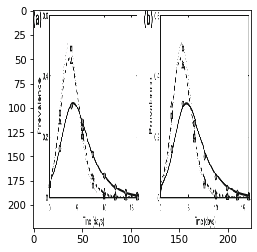

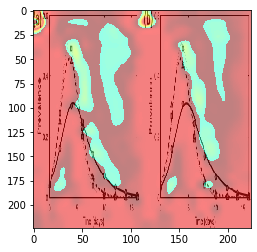

feat228-top2.png: 
cross - correlations in the gaussian variables lead to correlations of coincident level crossings. a spike correlations can arise from common input in a neuronal network. b we consider coincident level+crossings arising from two gaussian processes that share a common latent source . whenever the voltage crosses a threshold _ from below a spike is emitted . spikes are indicated by vertical solid lines . the vertical dotted+lines indicate the width of a time bin t used to compute spike counts u vi [ 0 , t ] ( _ ) , i = 1,2




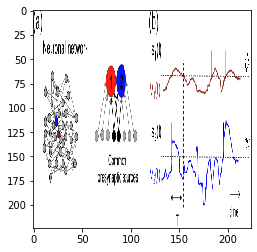

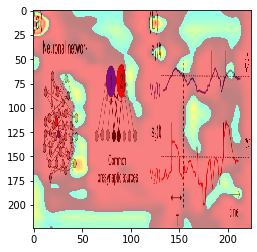

feat228-top3.png: 
a optical micrograph of a calcite grain containing stopping twins . orientation maps showing the angles b between crystal c-axis of domain 1 and laboratory x ? y direction , c between crystal c-axis of domain 2 and laboratory z-axis , d between crystal c-axis of domain 3 and laboratory y-axis . the numbered arrows refer to the three domains




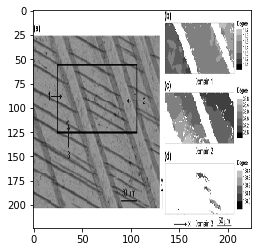

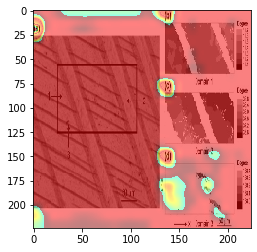

feat228-top4.png: 
prognostic value of soluble urokinase - type plasminogen activator receptor ( supar ) . box plot of ( a ) duration of mechanical ventilation and ( b ) length of stay in the icu of burn - injury patients with inhalation trauma . boxes represent the interquartile+ranges . n , number of patients per group . kaplan-meier curves showing the rate of freedom from ( c ) mechanical ventilation and ( d ) icu stay in burn - injury patients with systemic supar < 9.5 ng / ml and > 9.5 ng / ml . p values are given+in each panel .




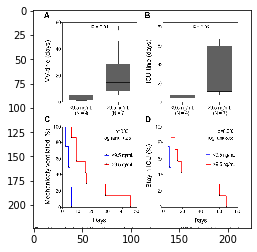

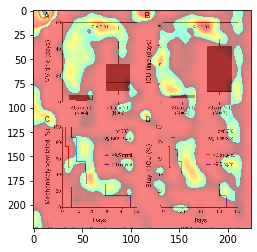

In [0]:
features = modelF.predict(figures[test])

diff_list = []
for i in range(512):
    media = np.mean(features[:,i])
    maximo = np.amax(features[:,i])
    diff_list.append(maximo-media)
arr = np.array(diff_list)
feats = arr.argsort()[-feat_n:][::-1]
for feat in feats:
    args = list(features[:,feat].argsort()[-img_n:][::-1])
    count = 0
    for arg in args:
        count = count +1
        print("feat"+str(feat)+"-top"+str(count)+".png: \n" + list_captions_tokens[test[arg]] +"\n\n")
        data = figures[test[arg],:,:,:]
        img = Image.fromarray(data, 'RGB')
        grads= visualize_cam(modelF, -1, feat, data)
        cam = cv2.applyColorMap(np.uint8(255*grads), cv2.COLORMAP_JET)
        cam = np.float32(cam) + np.float32(img)
        cam = 255 * cam / np.max(cam)
        cv2.imwrite("./scigraph/"+str(feat)+"-top"+str(count)+".png", cam)
        im = cv2.imread(list_figures_paths[test[arg]])
        plt.imshow(im)
        plt.show()
        im = cv2.imread("./scigraph/"+str(feat)+"-top"+str(count)+".png")
        plt.imshow(im)
        plt.show()

**Text features**

Similar to the visual case, we select the feature from the last block of the language subnetwork with the highest activation and show it heatmap. 

In [0]:
modelEmbeddings, modelVisualize, modelC = lre_aux.get_caption_vis_model()

The next parameters can change the number of features or captions for each feature you want to analyze.

In [0]:
feat_n = 4
capt_n = 4

With the next code we can generate the heatmap

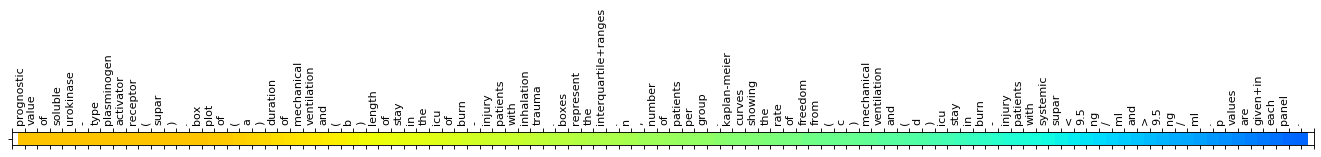

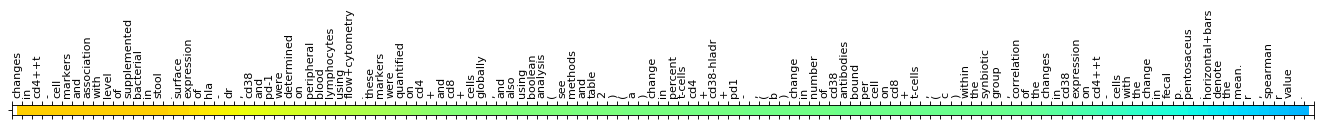

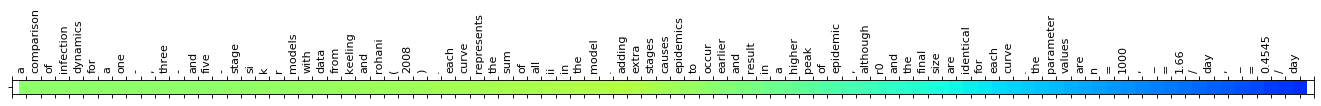

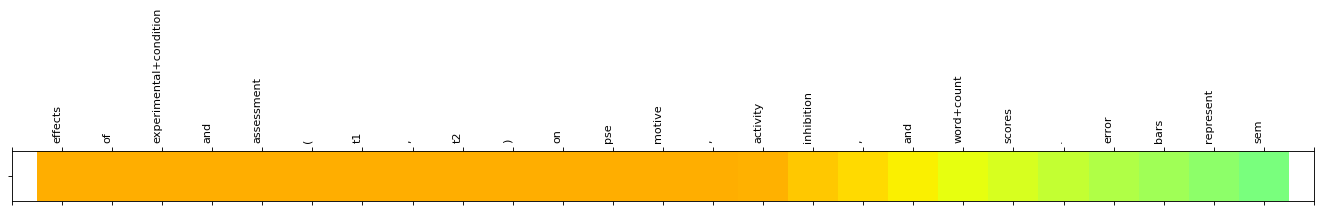

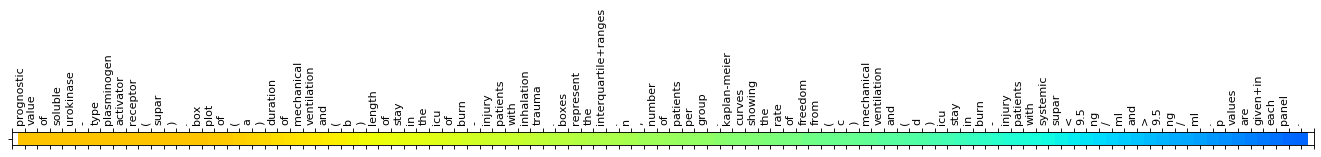

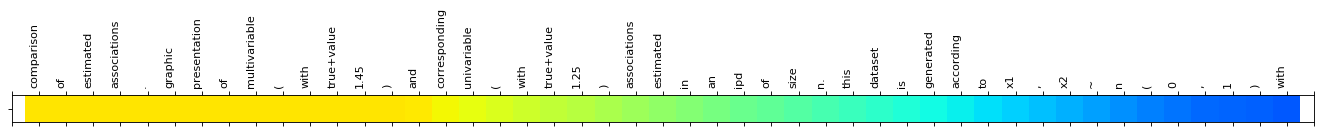

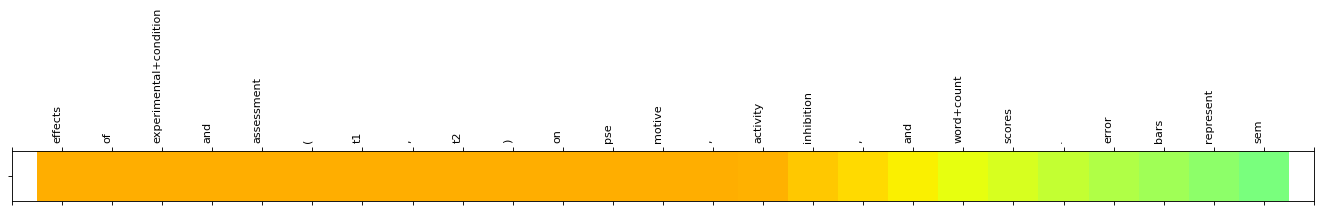

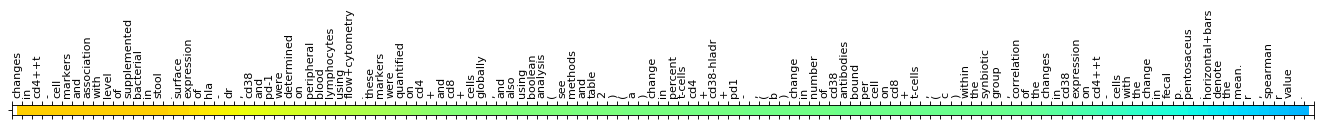

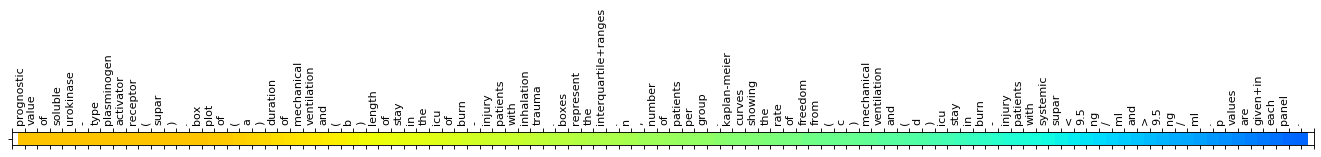

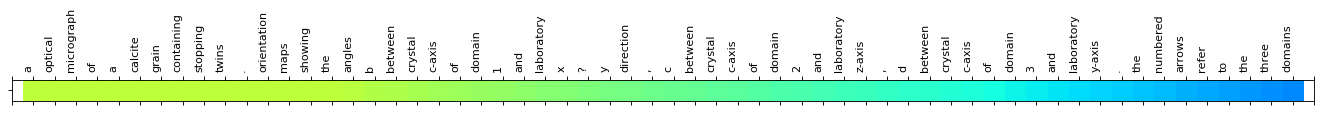

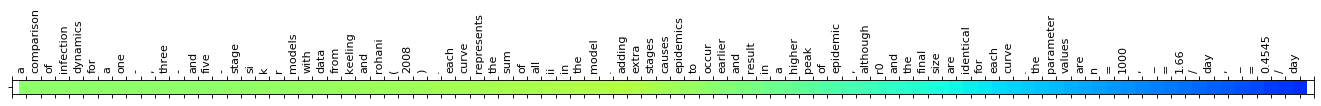

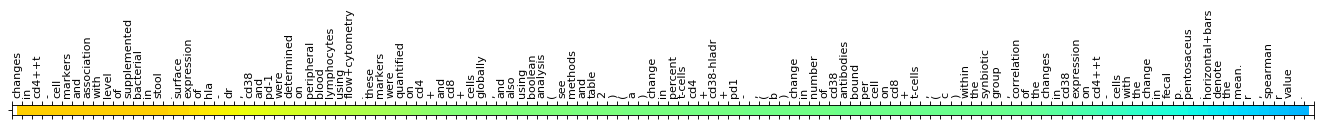

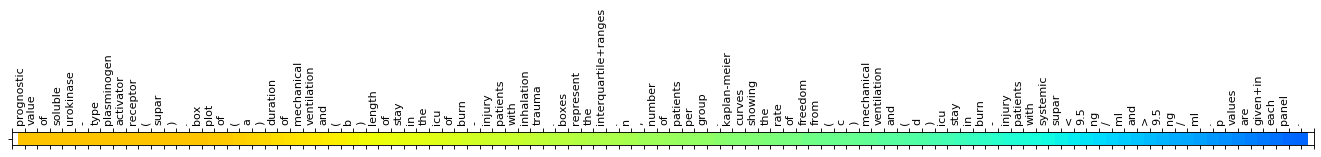

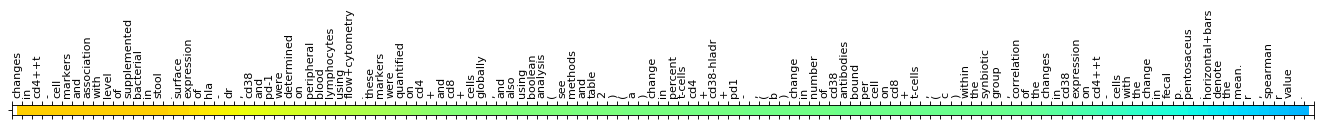

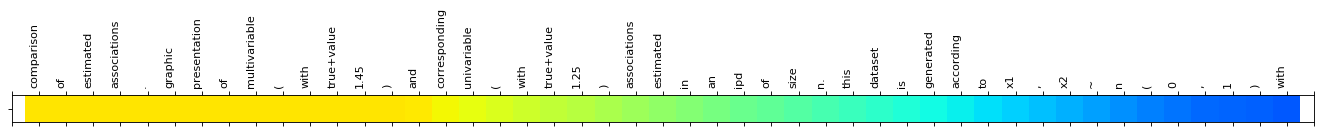

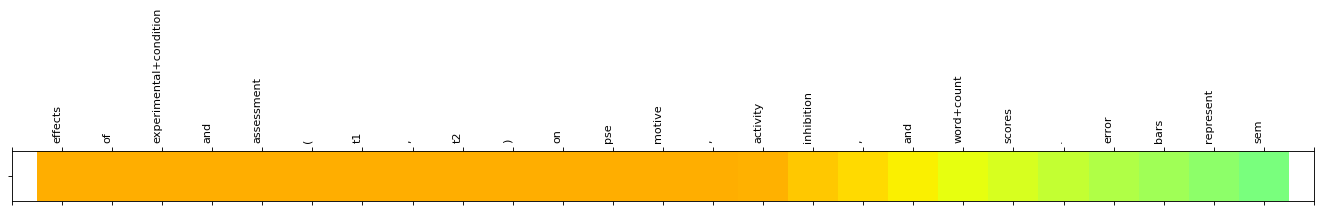

In [0]:
features = modelC.predict([captions_tokens[test], captions_tokens[test],captions_synsets[test]])

diff_list = []
for i in range(512):
    media = np.mean(features[:,i])
    maximo = np.amax(features[:,i])
    diff_list.append(maximo-media)
arr = np.array(diff_list)
feats = arr.argsort()[-feat_n:][::-1]
for feat in feats:
    args = list(features[:,feat].argsort()[-capt_n:][::-1])
    count = 0
    for arg in args:
        count = count +1
        data = modelEmbeddings.predict([np.expand_dims(captions_tokens[test[arg]],axis=0),np.expand_dims(captions_tokens[test[arg]],axis=0),np.expand_dims(captions_synsets[test[arg]],axis=0)])
        grads = lre_aux.grad_cam(modelVisualize,data,feat,-2)
        res = np.sum(np.array(grads),axis=1)
           
        question_len = len(list_captions_tokens[test[arg]].split(' '))
        alphaX = [list_captions_tokens[test[arg]].split(' ')[j] for j in range(question_len)]
  
        fig = plt.figure(figsize=(21, 12), dpi= 80, facecolor='w', edgecolor='k')
        
        ax = fig.add_subplot(211)
        ax.matshow(np.expand_dims(res[0:question_len],axis=0), cmap='jet', vmin=0., vmax=55.)
        ax.set_xticks(list(range(-1,question_len+1)))
        ax.set_xticklabels(['']+alphaX, rotation = 90, ha="right")
        ax.set_yticks(list(range(1)))
        ax.set_yticklabels([''])
                 
        plt.savefig("feat"+str(feat)+"-top"+str(count)+".png")

## 2. IMAGE-SENTENCE MATCHING

Understanding natural images has been a major area of research in computer vision, with well established datasets like [ImageNet](http://www.image-net.org),  [Flickr30K](https://www.aclweb.org/anthology/Q14-1006/) and [COCO](http://cocodataset.org). However, reasoning with other visual representations like scientific figures and diagrams has not received the same attention yet and entails additional challenges.

The next table from the [Look, Read and Enrich](https://arxiv.org/abs/1909.09070) paper shows the state-of-the-art baselines in image-sentence matching on the Flickr30K and COCO natural image datasets. Performance is measured in recall at k ($Rk$), with k=\{1,5,10\}. 

The table shows that the performance obtained by the FCC-based models on the natural images datasets is far from the state of the art.

<img src='https://github.com/hybridnlp/tutorial/blob/master/images/Table1.png?raw=true'>

**However, the situation reverts dramatically when the same models are trained and evaluated against scientific datasets like SciGraph and Semantic Scholar!** Note the comparison against the best image-sentence matching baseline DSVE-loc, trained against SciGraph and Semantic Scholar.

<img src='https://github.com/hybridnlp/tutorial/blob/master/images/Table2.png?raw=true'>

As shown in the table, using visual features enriched with pre-trained semantic embeddings (Ours<sub>vgg-vec</sub> and Ours<sub>vec</sub>) from Vecsigrafo during training of the FCC task further improves recall. 

Next, we illustrate how to run the previous bidirectional retrieval (caption -> figure and figure -> caption) tasks against a small Scigraph sample (40 figures and captions). Of course, the results will difer from those in the previous tables. Actually, as you will see they are much better because the search space is much smaller.

### 2.1. Best baseline (DSVE-loc)

From the baselines, we successfully reproduced DSVE-loc, using the [code](https://github.com/technicolor-research/dsve-loc) made available by the authors, and trained it on SciGraph. Since downloading and installing the materiales to run the dsve-loc testing takes approximately **15 minutes**, we will skip this step but you can run it on your own.

In [0]:
!pip install --upgrade torch
!pip install --upgrade visual_genome
!pip install --upgrade sru[cuda]
!pip install --upgrade scipy
!pip install --upgrade torchvision
!pip install --upgrade pycocotools
!pip install --upgrade nltk
!pip install --upgrade opencv-python
!pip install numpy==1.16.1

import nltk
nltk.download('punkt')

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.1+cu100)
     |████████████████████████████████| 25.2MB 1.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0


Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.2+cu100)
Requirement already up-to-date: pycocotools in /usr/local/lib/python3.6/dist-packages (2.0.0)
     |████████████████████████████████| 1.5MB 2.8MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449909 sha256=730ec4fb4a82f7d3725ab6cda3ddbe3f927d07a625c2c0a631d5d39a408cfb42
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 28.7MB 1.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 3.4.7.28
    Uninstalling opencv-python-3.4.7.28:
      Successfully uninstalled opencv-python-3.4.7.28


     |████████████████████████████████| 17.3MB 224kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.4
    Uninstalling numpy-1.17.4:
      Successfully uninstalled numpy-1.17.4


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

First, we clone the original DSVE-loc repository and the necessary materials indicated there:

In [0]:
!git clone https://github.com/technicolor-research/dsve-loc.git
!wget http://www.cs.toronto.edu/~rkiros/models/utable.npy
!wget http://www.cs.toronto.edu/~rkiros/models/dictionary.txt

Cloning into 'dsve-loc'...
remote: Enumerating objects: 31, done.
remote: Total 31 (delta 0), reused 0 (delta 0), pack-reused 31
Unpacking objects: 100% (31/31), done.
--2019-11-15 16:58:32--  http://www.cs.toronto.edu/~rkiros/models/utable.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2342138474 (2.2G)
Saving to: ‘utable.npy’

utable.npy          100%[===================>]   2.18G  16.0MB/s    in 2m 24s  

2019-11-15 17:00:56 (15.5 MB/s) - ‘utable.npy’ saved [2342138474/2342138474]

--2019-11-15 17:00:57--  http://www.cs.toronto.edu/~rkiros/models/dictionary.txt
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7996547 (7.6M) [text/plain]
Saving to: ‘dictionary.txt’

dic

Next, we download a DSVE-loc model pre-trained offline over the overall 82K SciGraph samples and a random selection of 40 new SciGraph samples in DSVE-loc-compatible format for evaluation:

In [0]:
!wget https://zenodo.org/record/3532713/files/best_scigraph.pth.tar?download=1
!unzip -o tutorial/datasamples/dsve-loc.zip

--2019-11-15 17:01:00--  https://zenodo.org/record/3532713/files/best_scigraph.pth.tar?download=1
Resolving zenodo.org (zenodo.org)... 188.184.65.20
Connecting to zenodo.org (zenodo.org)|188.184.65.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1016164743 (969M) [application/octet-stream]
Saving to: ‘best_scigraph.pth.tar?download=1’

best_scigraph.pth.t 100%[===================>] 969.09M  6.74MB/s    in 2m 11s  

2019-11-15 17:03:13 (7.40 MB/s) - ‘best_scigraph.pth.tar?download=1’ saved [1016164743/1016164743]

Archive:  tutorial/datasamples/dsve-loc.zip
   creating: dsve-loc/data/scigraph/
  inflating: dsve-loc/data/scigraph/scigraph_dsve_test.json  
  inflating: dsve-loc/eval_retrieval.py  
  inflating: dsve-loc/misc/config.py  
  inflating: dsve-loc/misc/evaluation.py  
  inflating: dsve-loc/misc/utils.py  
   creating: dsve-loc/misc/__pycache__/
  inflating: dsve-loc/misc/__pycache__/config.cpython-36.pyc  
  inflating: dsve-loc/misc/__pycache__/datas

Now, we run the bidirectional retrieval task. The results are two arrays with values of recall @ 1, 5 and 10. The first array contains figure retrieval (given a caption, obtain the corresponding figure) results, while the second contains the caption retrieval results.

In [0]:
!python ./dsve-loc/eval_retrieval.py -p "best_scigraph.pth.tar" -te

Loading model from: best_scigraph.pth.tar
Traceback (most recent call last):
  File "./dsve-loc/eval_retrieval.py", line 50, in <module>
    checkpoint = torch.load(args.model_path, map_location=lambda storage, loc: storage)
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 419, in load
    f = open(f, 'rb')
FileNotFoundError: [Errno 2] No such file or directory: 'best_scigraph.pth.tar'


### 2.2 Bidirectional retrieval based on FCC

To evaluate this task we implement the following algorithm:

1. Take each figure and its caption, 
2. take the score returned by the FCC model based on the probability that they correspond, expressed as a one-hot vector [0,1],
3. compare it with the scores obtained by the rest of the captions (or figures, if the task is figure retrieval): If there are less than 10 captions/figures with a better score than the correct one, it means that we have one more recall@10 point. Similar with recall@5 (less than 5) and recall@1 (only 1). 

The final count is divided by the number of samples in the test split, producing the final recall values.

In [0]:
r_at_1 = 0
r_at_5 = 0
r_at_10 = 0
for i in tqdm(test,total=len(test)):
    bx = []
    bx.append(np.expand_dims(captions_tokens[i],axis=0))
    bx.append(np.expand_dims(captions_tokens[i],axis=0))
    bx.append(np.expand_dims(captions_synsets[i],axis=0))
    bx.append(np.expand_dims(figures[i],axis=0))
    count_cand = 0
    good_pred = model.predict(bx)
    for j in test:
      if i == j:
        continue
      bx[-1] = np.expand_dims(figures[j],axis=0)
      cand_pred = model.predict(bx)
      if cand_pred[:,1] > good_pred[:,1]:
        count_cand = count_cand + 1
      if count_cand >= 10:
        break
    if count_cand < 10:
      r_at_10 = r_at_10 + 1
    if count_cand < 5:
      r_at_5 = r_at_5 + + 1
    if count_cand < 1:
      r_at_1 = r_at_1 + 1

print("\n")
print ("FIGURE RETRIEVAL (r@1: {}% r@5: {}% r@10: {}%".format((r_at_1*100)/(len(test)), (r_at_5*100)/(len(test)), (r_at_10*100)/(len(test))))

100%|██████████| 40/40 [00:32<00:00,  1.40it/s]



FIGURE RETRIEVAL (r@1: 15.0% r@5: 40.0% r@10: 60.0%


In [0]:
r_at_1 = 0
r_at_5 = 0
r_at_10 = 0
for i in tqdm(test,total=len(test)):
    bx = []
    bx.append(np.expand_dims(captions_tokens[i],axis=0))
    bx.append(np.expand_dims(captions_tokens[i],axis=0))
    bx.append(np.expand_dims(captions_synsets[i],axis=0))
    bx.append(np.expand_dims(figures[i],axis=0))
    count_cand = 0
    good_pred = model.predict(bx)
    for j in test:
      if i == j:
        continue
      bx[0] = np.expand_dims(captions_tokens[j],axis=0)
      bx[1] = np.expand_dims(captions_tokens[j],axis=0)
      bx[2] = np.expand_dims(captions_synsets[j],axis=0)
      cand_pred = model.predict(bx)
      if cand_pred[:,1] > good_pred[:,1]:
        count_cand = count_cand + 1
      if count_cand >= 10:
        break
    if count_cand < 10:
      r_at_10 = r_at_10 + 1
    if count_cand < 5:
      r_at_5 = r_at_5 + + 1
    if count_cand < 1:
      r_at_1 = r_at_1 + 1

print("\n")
print ("CAPTION RETRIEVAL (r@1: {}% r@5: {}% r@10: {}%".format((r_at_1*100)/(len(test)), (r_at_5*100)/(len(test)), (r_at_10*100)/(len(test))))

100%|██████████| 40/40 [00:30<00:00,  1.21it/s]



CAPTION RETRIEVAL (r@1: 10.0% r@5: 40.0% r@10: 50.0%


## 4. CAPTION AND FIGURE CLASSIFICATION

We take the pre-trained text and visual features resulting from training the FCC task and use the architecture of the language and vision subnetworks to train our classifiers against the SciGraph taxonomy. Note that here we train using fine-tuning over the whole model over a subset of 400 samples from SciGraph, hence the results will differ from the paper. The following table shows the complete results of this experiment reported there.

<img src='https://github.com/hybridnlp/tutorial/blob/master/images/Table4.png?raw=true' width=65%>

The first step is to obtain the categories of each figure and caption from the dataset file:

In [0]:
categories = []

for doc in dataset:
  categories.append(doc["category"])

lb = LabelBinarizer()
labels = lb.fit_transform(categories)   

  
print("SHAPE OF LABELS = " + str(np.shape(labels)))

SHAPE OF LABELS = (400, 5)


### 4.1 Caption classification

For this task, we train the model during 5 epochs with a batch size of 128:

In [0]:
EPOCHS = 5
BATCH_SIZE = 128

Then we take the model with the weights already loaded (modelCaptions) and add two fully-connected layers to classify the inputs into the five different categories that we previously selected (health, engineering, math, biology and computer science).

In [0]:
modelCaptions = lre_aux.get_model()[1]

modelCaptionsClassOut = Dense(128, activation='relu') (modelCaptions.output)
modelCaptionsClassOut = Dense(5, activation='softmax') (modelCaptionsClassOut)
modelCaptionsClass = Model(modelCaptions.inputs, modelCaptionsClassOut)

print(modelCaptionsClass.summary())

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_13_input (InputLayer) (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_14_input (InputLayer) (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_15_input (InputLayer) (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1000, 100)    10236300    embedding_13_input[0][0]         
___________________________________________________________________________________________

Finally, we train the model with the same train and test split of the dataset of the FCC task. This will take **10 seconds** approx.

In [0]:
adam = Adam()

modelCaptionsClass.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["categorical_accuracy"])
modelCaptionsClass.fit([captions_tokens[train], captions_tokens[train], captions_synsets[train]],labels[train], epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=[[captions_tokens[test], captions_tokens[test], captions_synsets[test]],labels[test]])

Train on 360 samples, validate on 40 samples
Epoch 1/5
360/360 [==============================] - 6s 17ms/step - loss: 1.4103 - categorical_accuracy: 0.3778 - val_loss: 1.3287 - val_categorical_accuracy: 0.3500
Epoch 2/5
360/360 [==============================] - 1s 3ms/step - loss: 0.9903 - categorical_accuracy: 0.5889 - val_loss: 1.0457 - val_categorical_accuracy: 0.6000
Epoch 3/5
360/360 [==============================] - 1s 3ms/step - loss: 0.7619 - categorical_accuracy: 0.7417 - val_loss: 0.8909 - val_categorical_accuracy: 0.7500
Epoch 4/5
360/360 [==============================] - 1s 3ms/step - loss: 0.5655 - categorical_accuracy: 0.8028 - val_loss: 0.7479 - val_categorical_accuracy: 0.7250
Epoch 5/5
360/360 [==============================] - 1s 3ms/step - loss: 0.3901 - categorical_accuracy: 0.8833 - val_loss: 0.7153 - val_categorical_accuracy: 0.7750


### 4.2 Figure classification

In this case, we train the model during 6 epochs with a batch size of 32:

In [0]:
EPOCHS = 6
BATCH_SIZE = 32

Then we load the weights from the FCC task and we add two fully-connected layers to classify the inputs into the five different categories.

In [0]:
modelFiguresClass = lre_aux.get_model()[0]
modelFiguresClass.add(Dense(128, activation='relu'))
modelFiguresClass.add(Dense(5, activation='softmax'))

modelFiguresClass.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_41 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_42 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_43 (Batc (None, 112, 112, 128)   

Finally, we train the model with the same train and test split of the dataset of the FCC task. It may take round **45 seconds**.

In [0]:
adam = Adam(lr=1e-4,decay=1e-5)

modelFiguresClass.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["categorical_accuracy"])
modelFiguresClass.fit(figures[train],labels[train], epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=[figures[test],labels[test]])

Train on 360 samples, validate on 40 samples
Epoch 1/6
360/360 [==============================] - 15s 41ms/step - loss: 3.3674 - categorical_accuracy: 0.4444 - val_loss: 1.8691 - val_categorical_accuracy: 0.3750
Epoch 2/6
360/360 [==============================] - 10s 28ms/step - loss: 0.9015 - categorical_accuracy: 0.6750 - val_loss: 1.1629 - val_categorical_accuracy: 0.6750
Epoch 3/6
360/360 [==============================] - 10s 28ms/step - loss: 0.5959 - categorical_accuracy: 0.8000 - val_loss: 1.2809 - val_categorical_accuracy: 0.5500
Epoch 4/6
360/360 [==============================] - 10s 28ms/step - loss: 0.4566 - categorical_accuracy: 0.8389 - val_loss: 1.0382 - val_categorical_accuracy: 0.6000
Epoch 5/6
360/360 [==============================] - 10s 28ms/step - loss: 0.3382 - categorical_accuracy: 0.9167 - val_loss: 1.0289 - val_categorical_accuracy: 0.6500
Epoch 6/6
360/360 [==============================] - 10s 28ms/step - loss: 0.2650 - categorical_accuracy: 0.9306 - val_l

## 5. TEXTBOOK QUESTION ANSWERING (TQA) FOR MULTI-MODAL MACHINE COMPREHENSION

We leverage the [TQA dataset developed by Kembhavi et al at AI2](http://vuchallenge.org/tqa.html) to evaluate the textual and visual features learnt by the FCC task in a multi-modal machine comprehension scenario involving multiple-choice question answering over text and diagrams. 

More details are given in the [Look, Read and Enrich paper](https://arxiv.org/abs/1909.09070). To make it short, the table below shows that using FCC features (TQA<sub>4</sub> and TQA<sub>5</sub>) improves over a number of baselines (random, [BiDAF](https://arxiv.org/abs/1611.01603), [MemoryNet](https://arxiv.org/abs/1503.08895), and [VQA](https://arxiv.org/abs/1505.00468)). 

Again, additional benefits come from the application of pre-trained semantic embeddings produced by Vecsigrafo, particularly when used to process the text in the TQA corpus (TQA<sub>9</sub> and TQA<sub>10</sub>).

<img src='https://github.com/hybridnlp/tutorial/blob/master/images/Table3.png?raw=true' width=85%>

Next, we go through the different steps to train and evaluate a TQA model using FCC features and semantic embeddings (TQA<sub>10</sub>).

### 5.1. Loading the dataset


In this notebook, we  focus on a subset of 401 diagram questions from the TQA corpus. First we save in a list all the images and text (tokens and synsets) of this subset. The TQA dataset comprises 6 types of textual information (paragraph, question, answer A, answer B, answer C and answer D) and 2 types of visual information (paragraph image and question image). Also, we save in a list the correct answer of each question as a one-hot vector.

In [0]:
text_tokens = [[] for _ in range(6)]
text_synsets = [[] for _ in range(6)]
image_paths = [[] for _ in range(2)]
correct_answers = []

with open("./tutorial/datasamples/tqa_wordnet.json", "r") as file:
  dataset = json.load(file)
for doc in dataset:
  text_tokens[0].append(doc["paragraph_tokens"])
  text_synsets[0].append(doc["paragraph_synsets"])
  if doc["paragraph_img"] == "":
    image_paths[0].append(doc["paragraph_img"])
  else:
    image_paths[0].append("./tqa/"+doc["paragraph_img"])
  text_tokens[1].append(doc["question_tokens"])
  text_synsets[1].append(doc["question_synsets"])
  if doc["question_img"] == "":
    image_paths[1].append(doc["question_img"])
  else:
    image_paths[1].append("./tqa/"+doc["question_img"])
  text_tokens[2].append(doc["answer_a_tokens"])
  text_synsets[2].append(doc["answer_a_synsets"])
  text_tokens[3].append(doc["answer_b_tokens"])
  text_synsets[3].append(doc["answer_b_synsets"])
  text_tokens[4].append(doc["answer_c_tokens"])
  text_synsets[4].append(doc["answer_c_synsets"])
  text_tokens[5].append(doc["answer_d_tokens"])
  text_synsets[5].append(doc["answer_d_synsets"])
  correct_answer = doc["correct_answer"]
  correct_array = np.zeros(4)
  letter_list=["a","b","c","d"]
  for i in range(4):
    if letter_list[i]==correct_answer:
      correct_array[i]=1
  correct_answers.append(correct_array)
correct_answers = np.array(correct_answers)
    
print("Number of paragraphs (tokens): " + str(len(text_tokens[0])))
print("Number of paragraphs (synsets): " + str(len(text_synsets[0])))
print("Number of paragraph images: " + str(len(image_paths[0])))
print("Number of questions (tokens): " + str(len(text_tokens[1])))
print("Number of questions (synsets): " + str(len(text_synsets[1])))
print("Number of question images: " + str(len(image_paths[1])))
print("Number of answers A (tokens): " + str(len(text_tokens[2])))
print("Number of answers A (synsets): " + str(len(text_synsets[2])))
print("Number of answers B (tokens): " + str(len(text_tokens[3])))
print("Number of answers B (synsets): " + str(len(text_synsets[3])))
print("Number of answers C (tokens): " + str(len(text_tokens[4])))
print("Number of answers C (synsets): " + str(len(text_synsets[4])))
print("Number of answers D (tokens): " + str(len(text_tokens[5])))
print("Number of answers D (synsets): " + str(len(text_synsets[5])))
print("Number of correct_answers: " + str(len(correct_answers)))

Number of paragraphs (tokens): 401
Number of paragraphs (synsets): 401
Number of paragraph images: 401
Number of questions (tokens): 401
Number of questions (synsets): 401
Number of question images: 401
Number of answers A (tokens): 401
Number of answers A (synsets): 401
Number of answers B (tokens): 401
Number of answers B (synsets): 401
Number of answers C (tokens): 401
Number of answers C (synsets): 401
Number of answers D (tokens): 401
Number of answers D (synsets): 401
Number of correct_answers: 401


Let us take a look at the corpus. You can change the index variable to retrieve different samples as you like.

PARAGRAPH: the upper layer of jupiters atmosphere contains clouds of ammonia ( nh3 ) in bands of different colors . these bands rotate around the planet , but also swirl around in turbulent storms . the great+red+spot ( figure 1.3 ) is an enormous , oval - shaped storm found south of jupiters equator . this storm is more than three times as wide as the entire earth . clouds in the storm rotate in a counterclockwise direction , making one complete turn every six days or so . the great+red+spot has been on jupiter for at+least 300 years , since astronomers could first see the storm through telescopes . do you think the great+red+spot is a permanent feature on jupiter ? how could you know ? this image of jupiters+great+red+spot ( upper right of image ) was taken by the voyager 1 spacecraft . the white storm just below the great+red+spot is about the same diameter as earth .


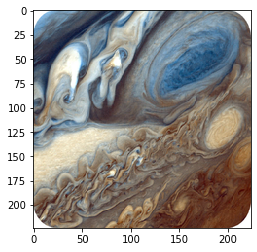

QUESTION: which of these are most affected by a storm ?


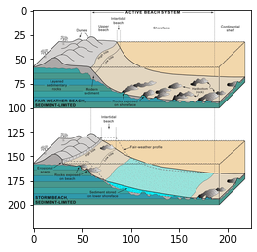

ANSWERS:

a. dunes
b. continental+shelf
c. shoreface
d. intertidal beach

CORRECT ANSWER: [0. 0. 0. 1.]


In [0]:
index = 2

print("PARAGRAPH: " + text_tokens[0][index])
try:
  im = cv2.imread(image_paths[0][index])
  plt.imshow(im)
  plt.show()
except:
  print("No paragraph image\n")

print("QUESTION: " + text_tokens[1][index])
im = cv2.imread(image_paths[1][index])
plt.imshow(im)
plt.show()


print("ANSWERS:\n")
print("a. " + text_tokens[2][index])
print("b. " + text_tokens[3][index])
print("c. " + text_tokens[4][index])
print("d. " + text_tokens[5][index]+"\n")

print("CORRECT ANSWER: "+ str(correct_answers[index]))



Next, we transform these lists into tensors. For images, we transform the images into numpy arrays and then extract the features after being processed with our pre-trained model:

In [0]:
modelImages = lre_aux.get_model()[0]

In [0]:
images = [[] for _ in range(2)]
for i, img_path_type in enumerate(image_paths):
  for img_path in tqdm(img_path_type,total=len(img_path_type)):
    f_img = open(figure_path, 'rb')
    im = Image.open(f_img)
    arr = np.array(im.convert(mode='RGB'))
    im.close()
    f_img.close()
    feat = modelImages.predict(np.expand_dims(arr,axis=0))
    images[i].extend(feat)
images[0] = np.array(images[0])
images[1] = np.array(images[1])
print("\nSHAPE OF PARAGRAPH IMAGES TENSOR: " + str(np.shape(images[0])))
print("SHAPE OF QUESTION IMAGES TENSOR: " + str(np.shape(images[1])))

100%|██████████| 401/401 [00:09<00:00, 44.48it/s]


SHAPE OF PARAGRAPH IMAGES TENSOR: (401, 512)
SHAPE OF QUESTION IMAGES TENSOR: (401, 512)


We generate the tokenizers for caption tokens and synsets:

In [0]:
text_types = [text_tokens, text_synsets]
tokenizers = []

for lst_txt in text_types:
  text_full = []
  for elem in lst_txt:
    text_full.extend(elem)
  tokenizer = Tokenizer(filters='')
  tokenizer.fit_on_texts(text_full)
  tokenizers.append(tokenizer)

tokenizer_tokens, tokenizer_synsets = tokenizers

print("SIZE OF TOKENS VOCABULARY: " + str(len(tokenizer_tokens.word_index)))
print("SIZE OF SYNSETS VOCABULARY: " + str(len(tokenizer_synsets.word_index)))

SIZE OF TOKENS VOCABULARY: 3509
SIZE OF SYNSETS VOCABULARY: 1375


and transform the captions into sequence arrays with a different length for each one. We apply the Pareto principle to select the best maximum length possible, covering the 80% of the tokens in the dataset for each type of text information.

In [0]:
txt_tokens = [[] for _ in range(6)]
txt_synsets = [[] for _ in range(6)]
max_lens = []
txt = [txt_tokens,txt_synsets]

for i, lst_txt in enumerate(text_types):
  for j, elem in enumerate(lst_txt):
    dict_count = Counter([len(x.split(" ")) for x in elem])
    threshold = 0.8*sum([len(x.split(" ")) for x in elem])
    sorted_by_key = sorted(dict_count.items(), key=lambda kv: kv[0])
    count = 0
    for e in sorted_by_key:
      if count >= threshold:
        break
      else:
        max_len = e[0]
        count = count + e[0]*e[1]
    sequences = tokenizers[i].texts_to_sequences(elem)
    txt[i][j] = pad_sequences(sequences, maxlen=max_len, padding="post", truncating="post")
    max_lens.append(max_len)

print("SHAPE OF PARAGRAPH TOKENS SEQUENCES: " + str(np.shape(txt_tokens[0])))
print("SHAPE OF QUESTION TOKENS SEQUENCES: " + str(np.shape(txt_tokens[1])))
print("SHAPE OF ANSWER A TOKENS SEQUENCES: " + str(np.shape(txt_tokens[2])))
print("SHAPE OF ANSWER B TOKENS SEQUENCES: " + str(np.shape(txt_tokens[3])))
print("SHAPE OF ANSWER C TOKENS SEQUENCES: " + str(np.shape(txt_tokens[4])))
print("SHAPE OF ANSWER D TOKENS SEQUENCES: " + str(np.shape(txt_tokens[5])))
print("SHAPE OF PARAGRAPH SYNSETS SEQUENCES: " + str(np.shape(txt_synsets[0])))
print("SHAPE OF QUESTION SYNSETS SEQUENCES: " + str(np.shape(txt_synsets[1])))
print("SHAPE OF ANSWER A SYNSETS SEQUENCES: " + str(np.shape(txt_synsets[2])))
print("SHAPE OF ANSWER B SYNSETS SEQUENCES: " + str(np.shape(txt_synsets[3])))
print("SHAPE OF ANSWER C SYNSETS SEQUENCES: " + str(np.shape(txt_synsets[4])))
print("SHAPE OF ANSWER D SYNSETS SEQUENCES: " + str(np.shape(txt_synsets[5])))

SHAPE OF PARAGRAPH TOKENS SEQUENCES: (401, 230)
SHAPE OF QUESTION TOKENS SEQUENCES: (401, 15)
SHAPE OF ANSWER A TOKENS SEQUENCES: (401, 6)
SHAPE OF ANSWER B TOKENS SEQUENCES: (401, 7)
SHAPE OF ANSWER C TOKENS SEQUENCES: (401, 6)
SHAPE OF ANSWER D TOKENS SEQUENCES: (401, 6)
SHAPE OF PARAGRAPH SYNSETS SEQUENCES: (401, 230)
SHAPE OF QUESTION SYNSETS SEQUENCES: (401, 15)
SHAPE OF ANSWER A SYNSETS SEQUENCES: (401, 6)
SHAPE OF ANSWER B SYNSETS SEQUENCES: (401, 7)
SHAPE OF ANSWER C SYNSETS SEQUENCES: (401, 6)
SHAPE OF ANSWER D SYNSETS SEQUENCES: (401, 6)


### 5.2 Building the model

We adapt the text+image baseline proposed by Kembhavi et al, replacing the visual features with those learnt by the FCC visual subnetwork and including pre-trained Vecsigrafo semantic embeddings, as we did in the previous experiments. In this case, we use element-wise addition to combine pre-trained lemma and concept embeddings with the word embeddings learnt by the network.

First, we load the embedding matrices as we did for the FCC task:

In [0]:
embedding_matrices = []
for tok_i in range(len(tokenizers)):
  embedding_matrix = np.zeros((len(tokenizers[tok_i].word_index) + 1, DIM))
  for word, i in tokenizers[tok_i].word_index.items():
    embedding_vector = embedding_indexes[tok_i].get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
  embedding_matrices.append(embedding_matrix)
embedding_matrix_tokens, embedding_matrix_synsets = embedding_matrices

print("SHAPE OF TOKENS MATRIX: " + str(np.shape(embedding_matrix_tokens)))
print("SHAPE OF SYNSETS MATRIX: " + str(np.shape(embedding_matrix_synsets)))

SHAPE OF TOKENS MATRIX: (3510, 100)
SHAPE OF SYNSETS MATRIX: (1376, 100)


Since our TQA model is rather large (over 1,2M parameters) , we use our lre_aux library (also available in our Github) to load it. To compile the model we use Adam optimization with learning rate 0.01. No dropout is used in this experiment.

In [0]:
dout = 0.0            #dropout
rdout = 0.0           #recurrent dropout
adam = Adam(lr=1e-2)

tqa_model = lre_aux.get_TQAmodel(DIM,embedding_matrix_tokens,embedding_matrix_synsets, dout, rdout, tokenizers, max_lens)
tqa_model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['categorical_accuracy'])

print(tqa_model.summary())
print("NUMBER OF LAYERS: " + str(len(tqa_model.layers)))

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M_scratch_input (InputLayer)    (None, 230)          0                                            
__________________________________________________________________________________________________
M_tokens_input (InputLayer)     (None, 230)          0                                            
__________________________________________________________________________________________________
M_synsets_input (InputLayer)    (None, 230)          0                                            
__________________________________________________________________________________________________
U_scratch_input (InputLayer)    (None, 15)           0                                            
___________________________________________________________________________________________

### 5.3. Training and evaluation

In this case, we train our model during 5 epochs, with a batch size of 128 multiple-choice questions:

In [0]:
BATCH_SIZE = 128
EPOCHS = 5

We build the input data following our model's structure:

In [0]:
train, test = train_test_split(range(np.shape(txt_tokens[0])[0]), test_size=0.1)
X_train = []
X_test = []
for x in range(6):
  X_train.append(txt_tokens[x][train])
  X_train.append(txt_tokens[x][train])
  X_train.append(txt_synsets[x][train])
  if (x <= 1):
    X_train.append(images[x][train])
  X_test.append(txt_tokens[x][test])
  X_test.append(txt_tokens[x][test])
  X_test.append(txt_synsets[x][test])
  if (x <= 1):
    X_test.append(images[x][test])
y_train = correct_answers[train]
y_test = correct_answers[test]

Finally, we train the model to respond to the questions:

In [0]:
tqa_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1)

Train on 360 samples, validate on 41 samples
Epoch 1/5
360/360 [==============================] - 8s 23ms/step - loss: 1.3992 - categorical_accuracy: 0.2833 - val_loss: 1.4422 - val_categorical_accuracy: 0.1707
Epoch 2/5
360/360 [==============================] - 2s 6ms/step - loss: 1.4102 - categorical_accuracy: 0.3944 - val_loss: 1.4462 - val_categorical_accuracy: 0.0976
Epoch 3/5
360/360 [==============================] - 2s 5ms/step - loss: 1.1987 - categorical_accuracy: 0.5333 - val_loss: 1.5684 - val_categorical_accuracy: 0.1463
Epoch 4/5
360/360 [==============================] - 2s 5ms/step - loss: 1.0441 - categorical_accuracy: 0.5806 - val_loss: 1.8139 - val_categorical_accuracy: 0.1463
Epoch 5/5
360/360 [==============================] - 2s 6ms/step - loss: 0.8473 - categorical_accuracy: 0.6500 - val_loss: 2.3695 - val_categorical_accuracy: 0.1707


## 6. CONCLUSIONS

In this notebook we have shown how to leverage the correspondence between figures and captions in scientific bibliography through a Figure-Caption Correspondence task (FCC) and how the resulting text and visual features can be enriched with semantic embeddings produced through the Vecsigrafo method. Such features have demonstrated to successfully solve transfer learning tasks involving classification and multi-modal question answering in challenging datasets, beating the previous state ofthe art in several occasions. 

Further details on the methods and experiments can be found in our paper [Look, Read and Enrich](https://arxiv.org/abs/1909.09070). All the materials and data necessary to reproduce the paper are available in our [GitHub repository](https://github.com/hybridnlp/look_read_and_enrich).

To cite our work, use the following BibTex entry:

<pre>
@inproceedings{LookReadEnrich19,
 author = {Gomez-Perez, Jose Manuel and Ortega, Raul},
 title = {Look, Read and Enrich. Learning from Scientific Figures and their Captions},
 booktitle = {Proceedings of the 10th International Conference on Knowledge Capture},
 series = {K-CAP '19},
 year = {2019},
 isbn = {978-1-4503-7008-0/19/11},
 location = {Marina del Rey, CA, USA},
 pages = {},
 numpages = {8},
 url = {},
 doi = {https://doi.org/10.1145/3360901.3364420},
 acmid = {},
 publisher = {ACM},
 address = {New York, NY, USA},
 keywords = {scientific figures, figure-caption correspondence, knowledge graphs, transfer learning, multimodal machine comprehension}} 
</pre>